**************
# Problem Statement
Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

## Dataset Description
This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 
#### 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

## Evaluation Metric
We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

## Submission format
Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference.
*****************


## **Importing necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# Data Modelling Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier,\
            ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier 

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import unicodedata
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string 
from nltk.stem import WordNetLemmatizer
import re
import copy

from sklearn.utils import resample

# model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dhobltru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dhobltru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dhobltru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## glance @ data

In [2]:
train_path = "train.csv"
test_path = "test.csv"

In [3]:
def read_data(filepath):
    df = pd.read_csv(filepath, encoding = 'UTF-8')
    return df

train_data = read_data(train_path)
test_data  = read_data(test_path)
print("train.shape: {} \ntest.shape: {}".format(train_data.shape, test_data.shape))

train.shape: (7274, 3) 
test.shape: (1819, 2)


In [4]:
train_data.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [5]:
test_data.head()

,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought


#  1.          Exploratory Data Analysis & Data Pre Processing


In [6]:
# global variables

SENTIMENT_TO_CODE = {"NEGATIVE": 0,
                     "NEUTRAL": 1,
                     "POSITIVE": 2,
                     "CANT_TELL": 3}
CODE_TO_SENTIMENT = {0: "NEGATIVE",
                     1: "NEUTRAL",
                     2: "POSITIVE",
                     3: "CANT_TELL"}


###  1.1 Load and Prepare dataset 

In [7]:
train = copy.deepcopy(train_data)
test  = copy.deepcopy(test_data)

print("Null-test",test.isnull().sum().sum())
print("Null-train",train.isnull().sum().sum())

Null-test 0
Null-train 1


In [8]:
train.dropna(inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7273 non-null int64
tweet        7273 non-null object
sentiment    7273 non-null int64
dtypes: int64(2), object(1)
memory usage: 227.3+ KB


In [10]:
train[train['sentiment']==SENTIMENT_TO_CODE["NEGATIVE"]].sample(3)

,tweet_id,tweet,sentiment
3068,421,IPhone is dead. Find me on the secret batphone...,0
6863,7303,Brought up how Google Maps had rerouted all im...,0
1929,7667,Horrible repressed memories of the Apple spinn...,0


In [11]:
train[train['sentiment']==SENTIMENT_TO_CODE["NEUTRAL"]].sample(3)

,tweet_id,tweet,sentiment
2931,2385,This is ackward. Sitting in the back of Ballro...,1
3444,1524,@mention ÛÏ@mention Google is NOT launching a...,1
5875,7467,@mention Probably be even more on the way back...,1


In [12]:
train[train['sentiment']==SENTIMENT_TO_CODE["POSITIVE"]].sample(3)

,tweet_id,tweet,sentiment
2016,9029,"[TOP STORY] At #SXSW, Apple schools the market...",2
4805,4062,@mention Last but not least get a copy of Stu...,2
4713,5384,RT @mention Almost every &quot;how do you ____...,2


In [13]:
train[train['sentiment']==SENTIMENT_TO_CODE["CANT_TELL"]].sample(3)

,tweet_id,tweet,sentiment
6733,9037,"@mention Yes, the Google presentation was not ...",3
5318,4096,Line a mile long outside. Lucky to get in just...,3
1209,5926,TR @mention Google (tries again) to launch a n...,3


In [14]:
train.drop(['tweet_id'],axis=1, inplace=True)
test.drop(['tweet_id'],axis=1, inplace=True)

###  **1.2 Check for Class Imbalance**

Counter({1: 4310, 2: 2382, 0: 456, 3: 125})


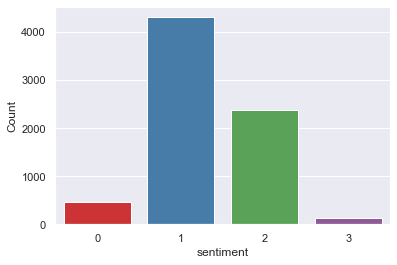

In [15]:
import collections

sentiment_counter = collections.Counter(train['sentiment'])
print(sentiment_counter)

sns.set(style="darkgrid")
ax1 = sns.countplot(x="sentiment", data=train, palette="Set1")
ax1.set(ylabel="Count")
plt.show()

[Text(0, 0.5, 'Percent')]

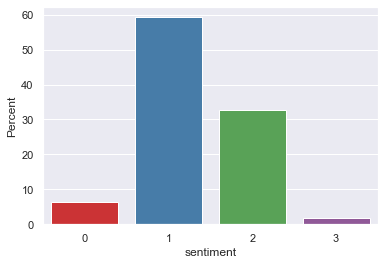

In [16]:
ax = sns.barplot(x="sentiment", y="sentiment", data=train, 
                 estimator=lambda x: len(x) / len(train) * 100,
                palette="Set1")
ax.set(ylabel="Percent")


# **Data Visualization**

### The distribution of the number of words in comment texts

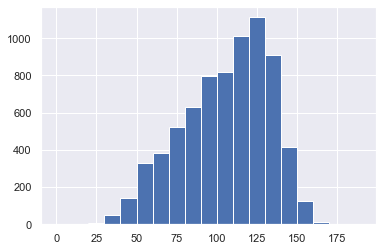

In [17]:
lens = train.tweet.str.len()
lens.hist(bins = np.arange(0,200,10))

wordcloud for 'NEGATIVE' sentiments


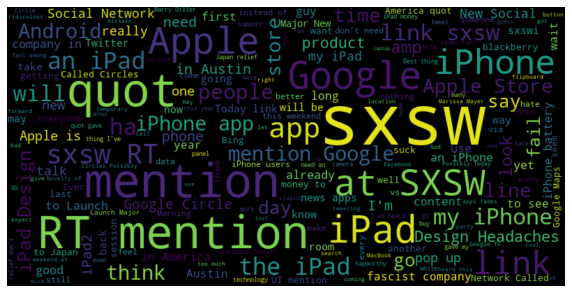

wordcloud for 'NEUTRAL' sentiments


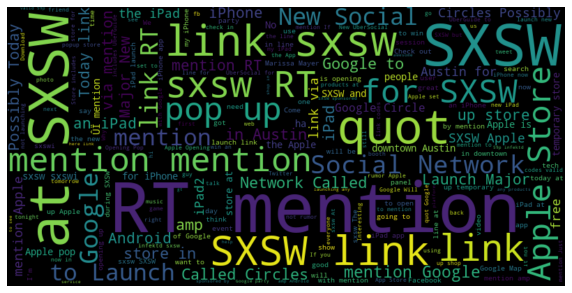

wordcloud for 'POSITIVE' sentiments


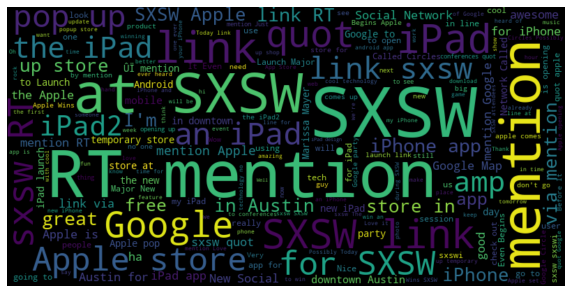

wordcloud for 'CANT_TELL' sentiments


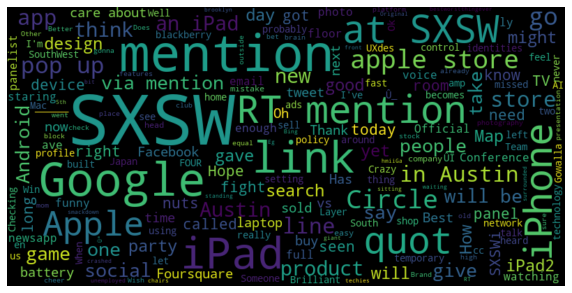

In [18]:
def create_wordcloud(train):
    wordcloud = WordCloud(background_color='black',
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)
    
    for i in range(len(CODE_TO_SENTIMENT)):
        sentiment = ' '.join([text for text in train.loc[train['sentiment'] == i, 'tweet']])
        print("wordcloud for '{}' sentiments".format(CODE_TO_SENTIMENT[i]))
        wordcloud.generate(sentiment)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()


create_wordcloud(train)

## **Preprocess Data**

In [19]:
stop_words = list(stopwords.words('english'))
wordcloud_stopwords = ['rt','mention','sxsw','link','apple',
                       'store','iphone','ipad','android','google']
stop_words.extend(wordcloud_stopwords)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = dataframe['cleaned'].str.replace('(\w+:\/\/\S+)|^rt|http.+?|[^\w\s]','')
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "@[\w]*")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "\d*")

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])
    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return dataframe 

train_p = preprocess(train) 
test_p  = preprocess(test) 


In [20]:
train_p.head()

,tweet,sentiment,cleaned
0,#sxswnui #sxsw #apple defining language of tou...,1,sxswnui defining language touch different dial...
1,Learning ab Google doodles! All doodles should...,1,learning ab doodle doodle light funny amp inno...
2,one of the most in-your-face ex. of stealing t...,2,one inyourface ex stealing show yr quotat scho...
3,This iPhone #SXSW app would b pretty awesome i...,0,app would pretty awesome didnt crash every min...
4,Line outside the Apple store in Austin waiting...,1,line outside austin waiting new


In [21]:
test_p.head()

,tweet,cleaned
0,Audience Q: What prototyping tools do you use?...,audience prototyping tool use sketchbookssharp...
1,At SXSW? Send Your Best Photos &amp; Videos to...,send best photo amp video citizen_journalism c...
2,@mention and here's a pic of you winning your...,here pic winning unsix cc cont
3,Google Marissa Mayer: mobile phone as a cursor...,marissa mayer mobile phone cursor physical loc...
4,#SXSW Google maps is even cooler than I thought,map even cooler thought


## Unigram Bigram Trigram

In [22]:
sent_NEG=train_p[train_p.sentiment == SENTIMENT_TO_CODE["NEGATIVE"]]
sent_NEU=train_p[train_p.sentiment == SENTIMENT_TO_CODE["NEUTRAL"]]
sent_POS=train_p[train_p.sentiment == SENTIMENT_TO_CODE["POSITIVE"]]
sent_CNT=train_p[train_p.sentiment == SENTIMENT_TO_CODE["CANT_TELL"]]

### Unigram

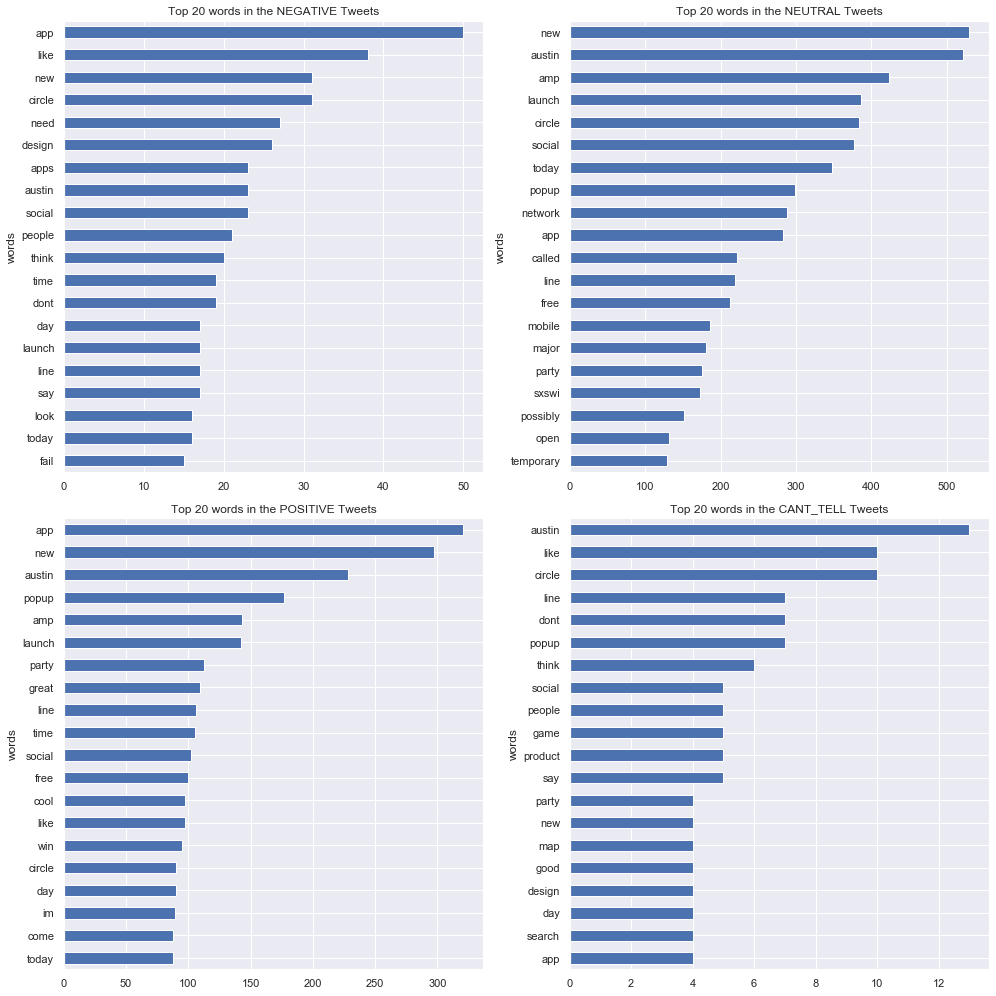

In [23]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:n]
    df = pd.DataFrame(words_freq, columns = ['words' , 'count'])
    return df

plt.figure(1, figsize=(14, 14))

ax1 = plt.subplot(221)
plt.title('Top 20 words in the NEGATIVE Tweets')
common_words_df = get_top_n_words(sent_NEG['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax1)

ax2 = plt.subplot(222)
plt.title('Top 20 words in the NEUTRAL Tweets')
common_words_df = get_top_n_words(sent_NEU['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax2)

ax3 = plt.subplot(223)
plt.title('Top 20 words in the POSITIVE Tweets')
common_words_df = get_top_n_words(sent_POS['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax3)

ax4 = plt.subplot(224)
plt.title('Top 20 words in the CANT_TELL Tweets')
common_words_df = get_top_n_words(sent_CNT['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax4)

plt.tight_layout()

### Bigram

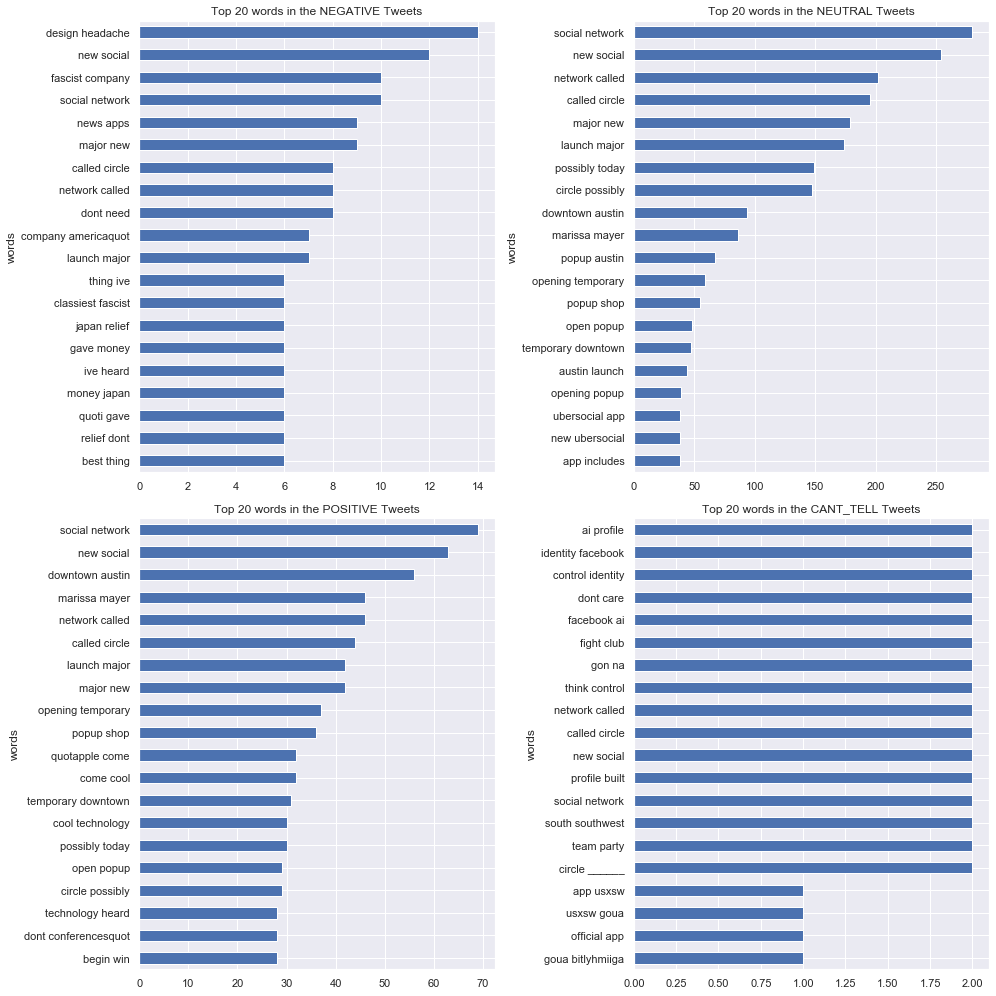

In [24]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:n]
    df = pd.DataFrame(words_freq, columns = ['words' , 'count'])
    return df

plt.figure(1, figsize=(14, 14))

ax1 = plt.subplot(221)
plt.title('Top 20 words in the NEGATIVE Tweets')
common_words_df =  get_top_n_bigram(sent_NEG['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax1)

ax2 = plt.subplot(222)
plt.title('Top 20 words in the NEUTRAL Tweets')
common_words_df = get_top_n_bigram(sent_NEU['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax2)

ax3 = plt.subplot(223)
plt.title('Top 20 words in the POSITIVE Tweets')
common_words_df = get_top_n_bigram(sent_POS['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax3)

ax4 = plt.subplot(224)
plt.title('Top 20 words in the CANT_TELL Tweets')
common_words_df = get_top_n_bigram(sent_CNT['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax4)

plt.tight_layout()

### Trigram

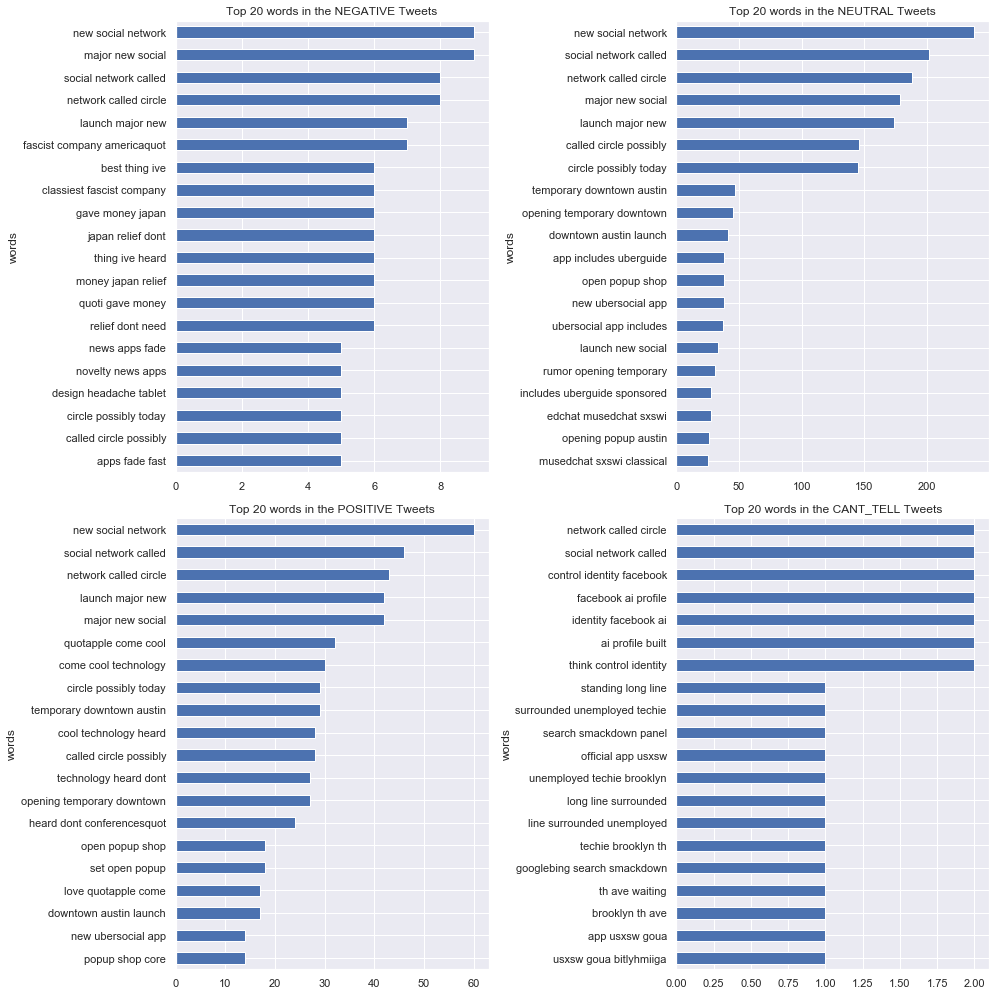

In [25]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:n]
    df = pd.DataFrame(words_freq, columns = ['words' , 'count'])
    return df

plt.figure(1, figsize=(14, 14))

ax1 = plt.subplot(221)
plt.title('Top 20 words in the NEGATIVE Tweets')
common_words_df = get_top_n_trigram(sent_NEG['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax1)

ax2 = plt.subplot(222)
plt.title('Top 20 words in the NEUTRAL Tweets')
common_words_df = get_top_n_trigram(sent_NEU['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax2)

ax3 = plt.subplot(223)
plt.title('Top 20 words in the POSITIVE Tweets')
common_words_df = get_top_n_trigram(sent_POS['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax3)

ax4 = plt.subplot(224)
plt.title('Top 20 words in the CANT_TELL Tweets')
common_words_df = get_top_n_trigram(sent_CNT['cleaned'], 20)
common_words_df.groupby('words').sum()['count'].sort_values().plot(kind='barh', ax=ax4)

plt.tight_layout()

In [26]:

def feature_engineering(df):
    
    punctuation = string.punctuation
  
    # number of punctuations
    df['num_punc'] = df['tweet'].apply(lambda tweet_msg: len([punct for punct in tweet_msg if punct in punctuation]))

    # Finding the number of words in the headline
    df['num_words'] = df['tweet'].apply(lambda tweet_msg: len(tweet_msg.split()))

    # the unique number of words in the headline
    df['num_unique_words'] = df['tweet'].apply(lambda tweet_msg: len(set(tweet_msg.split())))

    # the number of characters in the headline
    df['num_chars'] = df['tweet'].apply(lambda tweet_msg: len(tweet_msg))

    # number of genuine words with no stopwords  
    df['num_words_nostop'] = df['tweet'].apply(lambda tweet_msg: len([word for word in tweet_msg.split() if word not in stop_words]))

    # number of stopwords
    df['num_stop_words'] = df['num_words'] - df['num_words_nostop']

    return df


def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


In [27]:
train_fe = feature_engineering(train)
test_fe = feature_engineering(test)
print("train_fe.shape: ",train_fe.shape,"\n"\
      "test_fe.shape: ",test_fe.shape)

train_fe.shape:  (7273, 9) 
test_fe.shape:  (1819, 8)


In [28]:
print("Preprocessed Dataframe: " )
train_fe.head()

Preprocessed Dataframe: 


,tweet,sentiment,cleaned,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop_words
0,#sxswnui #sxsw #apple defining language of tou...,1,sxswnui defining language touch different dial...,3,12,12,89,10,2
1,Learning ab Google doodles! All doodles should...,1,learning ab doodle doodle light funny amp inno...,8,19,19,143,15,4
2,one of the most in-your-face ex. of stealing t...,2,one inyourface ex stealing show yr quotat scho...,12,22,19,132,15,7
3,This iPhone #SXSW app would b pretty awesome i...,0,app would pretty awesome didnt crash every min...,5,19,19,125,15,4
4,Line outside the Apple store in Austin waiting...,1,line outside austin waiting new,3,14,13,77,9,5


In [29]:
test_fe.head()

,tweet,cleaned,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop_words
0,Audience Q: What prototyping tools do you use?...,audience prototyping tool use sketchbookssharp...,11,18,18,138,16,2
1,At SXSW? Send Your Best Photos &amp; Videos to...,send best photo amp video citizen_journalism c...,16,17,17,124,17,0
2,@mention and here's a pic of you winning your...,here pic winning unsix cc cont,13,18,15,108,13,5
3,Google Marissa Mayer: mobile phone as a cursor...,marissa mayer mobile phone cursor physical loc...,3,23,22,125,17,6
4,#SXSW Google maps is even cooler than I thought,map even cooler thought,1,9,9,47,7,2


# **Baseline Model and Feature Engineering**

## **Applying a baseline model**

In [30]:
def xy_separator(df):
    X = df.drop('sentiment', axis=1)
    y = df['sentiment']
    return X,y

X_train_data, y_train_data = xy_separator(train_p)
X_test_data = test_p

In [31]:
def run_model(dataframe,
              target,
              vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=0.1),
              model=MultinomialNB()
             ):
    '''
    Performs model training and validate using f1-score
    '''
    X = dataframe
    y = target
    vect = vectorizer
    
    # splitting data into training and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # Vectorize
    vector = vect.fit(X_train['cleaned'])
    X_train_vect = vector.transform(X_train['cleaned']).toarray()
    X_valid_vect = vector.transform(X_valid['cleaned']).toarray()
    
    # Fit and predict
    model.fit(X_train_vect, y_train)  
    y_pred = model.predict(X_valid_vect)  
    
    #validation using f1-score
    c_report = classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return F1_score, y_pred

#### 1. 1  LogisticRegression - CountVectorizer

In [32]:
model = LogisticRegression(class_weight="balanced", random_state=0)
vectorizer = CountVectorizer(ngram_range=(1,3), binary=False, min_df=1)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.47      0.31      0.37       137
           1       0.71      0.79      0.75      1291
           2       0.58      0.51      0.54       724
           3       0.11      0.07      0.08        30

    accuracy                           0.66      2182
   macro avg       0.47      0.42      0.44      2182
weighted avg       0.64      0.66      0.65      2182

F1_score:  0.6462236994164287
Model - LogisticRegression(class_weight='balanced', random_state=0) 
Vectorizer - CountVectorizer(ngram_range=(1, 3))


#### 1.2  LogisticRegression - TfidfVectorizer

In [33]:
model = LogisticRegression(class_weight="balanced", random_state=0)
vectorizer = TfidfVectorizer(ngram_range=(1,2), binary=True)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.31      0.41      0.35       137
           1       0.73      0.68      0.71      1291
           2       0.54      0.58      0.56       724
           3       0.05      0.03      0.04        30

    accuracy                           0.62      2182
   macro avg       0.41      0.43      0.41      2182
weighted avg       0.63      0.62      0.63      2182

F1_score:  0.6257488122549608
Model - LogisticRegression(class_weight='balanced', random_state=0) 
Vectorizer - TfidfVectorizer(binary=True, ngram_range=(1, 2))


#### 2. 1  DecisionTreeClassifier - CountVectorizer

In [34]:
model = DecisionTreeClassifier(class_weight="balanced", random_state=0,criterion="entropy", max_depth=4)
vectorizer = CountVectorizer(ngram_range=(1,3), binary=True, min_df=1)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.43      0.02      0.04       137
           1       0.73      0.17      0.28      1291
           2       0.26      0.03      0.06       724
           3       0.02      0.93      0.03        30

    accuracy                           0.13      2182
   macro avg       0.36      0.29      0.10      2182
weighted avg       0.54      0.13      0.19      2182

F1_score:  0.1873895103172459
Model - DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=0) 
Vectorizer - CountVectorizer(binary=True, ngram_range=(1, 3))


#### 2.2  DecisionTreeClassifier - TfidfVectorizer

In [35]:
model = DecisionTreeClassifier(class_weight="balanced", random_state=0,criterion="entropy", max_depth=4)
vectorizer = TfidfVectorizer(ngram_range=(1,2), binary=True)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.33      0.01      0.03       137
           1       0.73      0.13      0.22      1291
           2       0.27      0.03      0.06       724
           3       0.02      0.93      0.03        30

    accuracy                           0.10      2182
   macro avg       0.34      0.28      0.08      2182
weighted avg       0.54      0.10      0.15      2182

F1_score:  0.1531979624997451
Model - DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=0) 
Vectorizer - TfidfVectorizer(binary=True, ngram_range=(1, 2))


#### 3.1  RandomForestClassifier - CountVectorizer

In [36]:
model = RandomForestClassifier(class_weight="balanced", random_state=0,criterion="entropy", 
                               max_depth=5, max_samples=200)
vectorizer = CountVectorizer(ngram_range=(1,3), binary=True, min_df=1)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       1.00      0.01      0.03       137
           1       0.62      0.76      0.69      1291
           2       0.42      0.35      0.38       724
           3       0.00      0.00      0.00        30

    accuracy                           0.57      2182
   macro avg       0.51      0.28      0.27      2182
weighted avg       0.57      0.57      0.54      2182

F1_score:  0.5351762081474091
Model - RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_samples=200, random_state=0) 
Vectorizer - CountVectorizer(binary=True, ngram_range=(1, 3))


#### 3.2  RandomForestClassifier - TfidfVectorizer


In [37]:
model = RandomForestClassifier(class_weight="balanced", random_state=0,criterion="entropy", 
                               max_depth=5, max_samples=200)
vectorizer = TfidfVectorizer(ngram_range=(1,2), binary=True)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.43      0.02      0.04       137
           1       0.61      0.73      0.67      1291
           2       0.38      0.33      0.35       724
           3       0.00      0.00      0.00        30

    accuracy                           0.54      2182
   macro avg       0.35      0.27      0.27      2182
weighted avg       0.52      0.54      0.51      2182

F1_score:  0.5144141129240898
Model - RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_samples=200, random_state=0) 
Vectorizer - TfidfVectorizer(binary=True, ngram_range=(1, 2))


#### 3.1  MultinomialNB - CountVectorizer

In [38]:
model = MultinomialNB(alpha=1.0, fit_prior=False)
vectorizer = CountVectorizer(ngram_range=(1,2), binary=True, min_df=1)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.58      0.28      0.37       137
           1       0.70      0.78      0.73      1291
           2       0.55      0.51      0.53       724
           3       0.11      0.03      0.05        30

    accuracy                           0.65      2182
   macro avg       0.48      0.40      0.42      2182
weighted avg       0.63      0.65      0.64      2182

F1_score:  0.6353524600498272
Model - MultinomialNB(fit_prior=False) 
Vectorizer - CountVectorizer(binary=True, ngram_range=(1, 2))


#### 3.2  MultinomialNB - TfidfVectorizer

In [39]:
model = MultinomialNB(alpha=1.0, fit_prior=False)
vectorizer = TfidfVectorizer(ngram_range=(1,2), binary=True, min_df=1)

F1_score, y_pred = run_model(X_train_data, y_train_data, vectorizer = vectorizer, model =model) 
print('===='*20)
print('Model - '+str(model),
      '\nVectorizer - '+str(vectorizer))
print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.66      0.24      0.35       137
           1       0.67      0.85      0.75      1291
           2       0.59      0.40      0.47       724
           3       0.12      0.03      0.05        30

    accuracy                           0.65      2182
   macro avg       0.51      0.38      0.41      2182
weighted avg       0.64      0.65      0.62      2182

F1_score:  0.6243388744554182
Model - MultinomialNB(fit_prior=False) 
Vectorizer - TfidfVectorizer(binary=True, ngram_range=(1, 2))


 ## Up-sample Minority Class

In [40]:
train_p_majority_NEU = train_p[train_p.sentiment==SENTIMENT_TO_CODE["NEUTRAL"]]

train_p_minority_NEG = train_p[train_p.sentiment==SENTIMENT_TO_CODE["NEGATIVE"]]
train_p_minority_POS = train_p[train_p.sentiment==SENTIMENT_TO_CODE["POSITIVE"]]
train_p_minority_CNT = train_p[train_p.sentiment==SENTIMENT_TO_CODE["CANT_TELL"]]

df_minority_upsampled_NEG = resample(train_p_minority_NEG, 
                                 replace=True,      # sample with replacement
                                 n_samples=4310,    # to match majority class
                                 random_state=0)    # reproducible results
df_minority_upsampled_POS = resample(train_p_minority_POS, 
                                 replace=True,      # sample with replacement
                                 n_samples=4310,    # to match majority class
                                 random_state=0)    # reproducible results
df_minority_upsampled_CNT = resample(train_p_minority_CNT, 
                                 replace=True,      # sample with replacement
                                 n_samples=4310,    # to match majority class
                                 random_state=0)    # reproducible results

df_upsampled = pd.concat([train_p_majority_NEU, df_minority_upsampled_NEG,
                          df_minority_upsampled_POS, df_minority_upsampled_CNT])

print(df_upsampled.shape)
X_train_data_upsampled, y_train_data_upsampled = xy_separator(df_upsampled)
X_test_data = test_pu

(17240, 9)


#### check class imbalance after upsampling

Counter({1: 4310, 0: 4310, 2: 4310, 3: 4310})


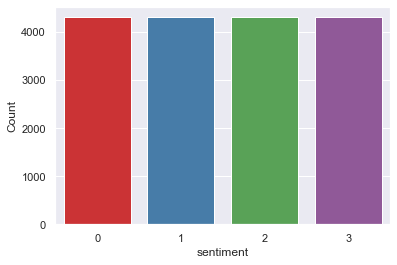

In [56]:
import collections

sentiment_counter = collections.Counter(df_upsampled['sentiment'])
print(sentiment_counter)

sns.set(style="darkgrid")
ax1 = sns.countplot(x="sentiment", data=df_upsampled, palette="Set1")
ax1.set(ylabel="Count")
plt.show()

[Text(0, 0.5, 'Percent')]

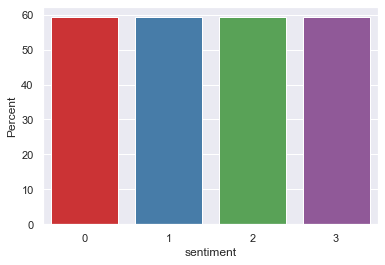

In [57]:
ax = sns.barplot(x="sentiment", y="sentiment", data=df_upsampled, 
                 estimator=lambda x: len(x) / len(train) * 100,
                palette="Set1")
ax.set(ylabel="Percent")


In [41]:
LR = OneVsRestClassifier(LogisticRegression(class_weight="balanced", random_state=0))
LR_CV = CountVectorizer(ngram_range=(1,3), binary=False)
LR_TF = TfidfVectorizer(ngram_range=(1,2), binary=True)

DT = OneVsRestClassifier(DecisionTreeClassifier(class_weight="balanced", random_state=0,criterion="entropy", max_depth=4))
DT_CV = CountVectorizer(ngram_range=(1,3), binary=True)
DT_TF = TfidfVectorizer(ngram_range=(1,2), binary=True)

RF = OneVsRestClassifier(RandomForestClassifier(class_weight="balanced", random_state=0,criterion="entropy", max_depth=5, max_samples=200))
RF_CV = CountVectorizer(ngram_range=(1,3), binary=True)
RF_TF = TfidfVectorizer(ngram_range=(1,2), binary=True)

MNB = OneVsRestClassifier(MultinomialNB(alpha=1.0, fit_prior=False))
MNB_CV = CountVectorizer(ngram_range=(1,2), binary=True)
MNB_TF = TfidfVectorizer(ngram_range=(1,2), binary=True, min_df=1)

model_vect_pairs = [{"model":LR,"vect":LR_CV},
                   {"model":LR,"vect":LR_TF},
                   {"model":DT,"vect":DT_CV},
                   {"model":DT,"vect":DT_TF},
                   {"model":RF,"vect":RF_CV},
                   {"model":RF,"vect":RF_TF},
                   {"model":MNB,"vect":MNB_CV},
                   {"model":MNB,"vect":MNB_TF}]

In [42]:
for model_vect_pair in model_vect_pairs:
    model = model_vect_pair["model"]
    vectorizer = model_vect_pair["vect"]
    F1_score, y_pred = run_model(X_train_data_upsampled, y_train_data_upsampled, vectorizer = vectorizer, model = model) 
    print('===='*20)
    print('Model - '+str(model),
          '\nVectorizer - '+str(vectorizer))
    print('===='*20)

classification report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1318
           1       0.83      0.78      0.80      1244
           2       0.82      0.84      0.83      1297
           3       0.98      1.00      0.99      1313

    accuracy                           0.90      5172
   macro avg       0.90      0.90      0.90      5172
weighted avg       0.90      0.90      0.90      5172

F1_score:  0.9019830168151874
Model - OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 random_state=0)) 
Vectorizer - CountVectorizer(ngram_range=(1, 3))
classification report: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      1318
           1       0.78      0.69      0.73      1244
           2       0.78      0.81      0.79      1297
           3       0.97      1.00      0.98      1313

    accuracy   

# **Ensembling**

In [43]:
%%time
def ensemble(dataframe,target):
    X = dataframe
    y = target
    
    CV = CountVectorizer(ngram_range=(1, 3))
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
     
    # TF-IDF feature matrix
    CV.fit(X_train['cleaned'])
    X_train_vect = CV.transform(X_train['cleaned']).toarray()
    X_valid_vect = CV.transform(X_valid['cleaned']).toarray()
   
    model1 = LR
    model2 = MNB
    
    model = VotingClassifier(estimators=[('lr', model1),('mnb', model2)], voting='soft')
    
    model.fit(X_train_vect,y_train)
    y_pred = model.predict(X_valid_vect) 
    
    #validation using f1-score
    c_report = classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score)
    return CV, model

final_vectrizer, final_model = ensemble(X_train_data_upsampled, y_train_data_upsampled)

classification report: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      1318
           1       0.82      0.69      0.75      1244
           2       0.80      0.84      0.82      1297
           3       0.95      1.00      0.97      1313

    accuracy                           0.88      5172
   macro avg       0.88      0.88      0.87      5172
weighted avg       0.88      0.88      0.88      5172

F1_score:  0.8761381844687642
CPU times: user 16min 22s, sys: 53 s, total: 17min 15s
Wall time: 5min 32s


# **Final Submission**

In [44]:
X_test_vect = final_vectrizer.transform(X_test_data['cleaned']).toarray()

final_pred = final_model.predict(X_test_vect)

In [45]:
#Create a  DataFrame with the tweet_id and our prediction regarding sentiment
submission = pd.DataFrame({'tweet_id':test_data['tweet_id'],'Sentiment':final_pred})
print(submission.shape)
submission.head()


(1819, 2)


,tweet_id,Sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [47]:
submission.to_csv('submission.csv', index=False)